<a href="https://colab.research.google.com/github/carbotton/tdl_tarea_1/blob/eda_preproc_data-aug/Tarea_1_letra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 1 - Taller de Deep Learning

**Fecha de entrega: 19/10/2025**  
**Puntaje máximo: 15**

## Introducción

El objetivo de esta tarea es evaluar su conocimiento sobre Deep Learning aplicado a un caso de uso real. En particular, vamos a evaluar la performance de sus modelos en una tarea de clasificación de escenas.

**Dataset**

El dataset a ser utilizado es **Imagenette**, una versión simplificada de ImageNet que consiste de 10 clases. Pueden encontrar más información y descargarlo en el siguiente [link](https://pytorch.org/vision/main/generated/torchvision.datasets.Imagenette.html).

**Tarea**

Tienen total libertad sobre cómo implementar y resolver el problema así como las técnicas y herramientas que quieran usar. Recomendamos usar Colab por simplicidad, pero pueden implementarlo en sus máquinas si así lo prefieren. La única limitante es que esperamos que la entrega sea en formato .ipynb (Jupyter Notebook) **con las celdas ya ejecutadas**.

**Restricciones**

- No se permite utilizar models pre-entrenados (cada modelo debe ser implementado desde cero)
- Se requiere que utilicen al menos 2 técnicas de **regularización** (Dropout, BatchNorm, Data Augmentation, etc.)
- Se requiere realizar un **análisis de los datos**, que incluya el balanceo de clases y tomar decisiones en base al análisis realizado.
- Las decisiones tomadas sobre el preprocesamiento de las imágenes (transforms, augmentation, etc.) deben ser resultado de la exploración del dataset y estar propiamente justificadas (una sección de exploración en el notebook con comentarios es suficiente).

**Reporte**

En particular, les pedimos que reporten: accuracy, precision, recall y f1.
También se espera poder observar la evolución del modelo (en los datos de train y validación) a medida que se entrena (logs, gráficas, etc).

**Evidencia de Experimentos**

Además, deben presentar evidencia de correr experimentos usando [Weights & Biases (wandb)](https://wandb.ai/). Esto incluye:
- Registros detallados de los experimentos.
- Gráficas y logs de entrenamiento.
- Comparaciones entre diferentes configuraciones de modelos.

# Integrantes del grupo

Natalia Campiglia - 

Maria Jose Carbajal - 241319

# Lo que hicimos...

Empezamos probando LeNet. Sabiamos que el resultado no iba a ser el mejor pero quisimos probar hasta donde podiamos llegar haciendole algunas modificaciones.

Luego de esto decidimos utilizar DenseNet.
Probamos con una DenseNet121 con algunas modificaciones y los resultados fueron mucho mejores, notando grandes diferencias.

# Librerias y definiciones

In [2]:
!pip install torchinfo

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import v2 as T
from torchvision.io import read_image, ImageReadMode

from torchinfo import summary
import wandb

import os
from pathlib import Path

from utils import (
    train,
    evaluate,
    model_classification_report,
    show_tensor_image,
    show_tensor_images,
    plot_training,
    EarlyStopping,
    print_log,
)

In [4]:
# Fijamos la semilla para que los resultados sean reproducibles
SEED = 34

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
import sys
import os

# Configurar límite de memoria MPS para evitar errores de memoria
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"

# definimos el dispositivo que vamos a usar
DEVICE = "cpu"  # por defecto, usamos la CPU
if torch.cuda.is_available():
    DEVICE = "cuda"  # si hay GPU, usamos la GPU
elif torch.backends.mps.is_available():
    DEVICE = "mps"  # si no hay GPU, pero hay MPS, usamos MPS
elif torch.xpu.is_available():
    DEVICE = "xpu"  # si no hay GPU, pero hay XPU, usamos XPU

print(f"Usando {DEVICE}")

NUM_WORKERS = 0 # Win y MacOS pueden tener problemas con múltiples workers
if sys.platform == 'linux':
    NUM_WORKERS = 4  # numero de workers para cargar los datos (depende de cada caso)

print(f"Usando {NUM_WORKERS}")

Usando cuda
Usando 4


In [6]:
BATCH_SIZE = 32  # tamaño del batch reducido para evitar problemas de memoria

# Exploracion de datos

## Carga de datos

In [7]:
DATA_DIR = Path("data")

# cargamos train y lo dividimos en train y val
imagenette_full_train = datasets.Imagenette(
    DATA_DIR, split="train", download=True
)

In [8]:
name_classes = imagenette_full_train.classes # no puedo usar imagenette_train_dataset.classes porque es un subset (surge de haber hecho el random split, no tengo mas atributos de clase ahi
NUM_CLASES = len(name_classes)

print(f"Clases: {name_classes}")

Clases: [('tench', 'Tinca tinca'), ('English springer', 'English springer spaniel'), ('cassette player',), ('chain saw', 'chainsaw'), ('church', 'church building'), ('French horn', 'horn'), ('garbage truck', 'dustcart'), ('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser'), ('golf ball',), ('parachute', 'chute')]


## Número de clases y cantidad de imagenes por clase

In [9]:
root_dir = "data/imagenette2/train"
classes = os.listdir(root_dir)

class_counts = {}
for cls in classes:
    n_images = len(os.listdir(os.path.join(root_dir, cls)))
    class_counts[cls] = n_images

# Encontrar la clase con menos y más imágenes
min_class = min(class_counts, key=class_counts.get)
max_class = max(class_counts, key=class_counts.get)

print(f"\nClase con MENOS imágenes: {min_class} ({class_counts[min_class]} imágenes)")
print(f"Clase con MÁS imágenes:  {max_class} ({class_counts[max_class]} imágenes)")
print(f"\nLa clase {max_class} tiene {((class_counts[max_class]-class_counts[min_class])/class_counts[max_class])*100:.1f}% más de imágenes que la clase {min_class}")



Clase con MENOS imágenes: n03000684 (859 imágenes)
Clase con MÁS imágenes:  n02979186 (994 imágenes)

La clase n02979186 tiene 13.6% más de imágenes que la clase n03000684


Todas tienen cantidades similares de imágenes.

Entre la clase que menos tiene y la que más, hay una diferencia de 135 imagenes.

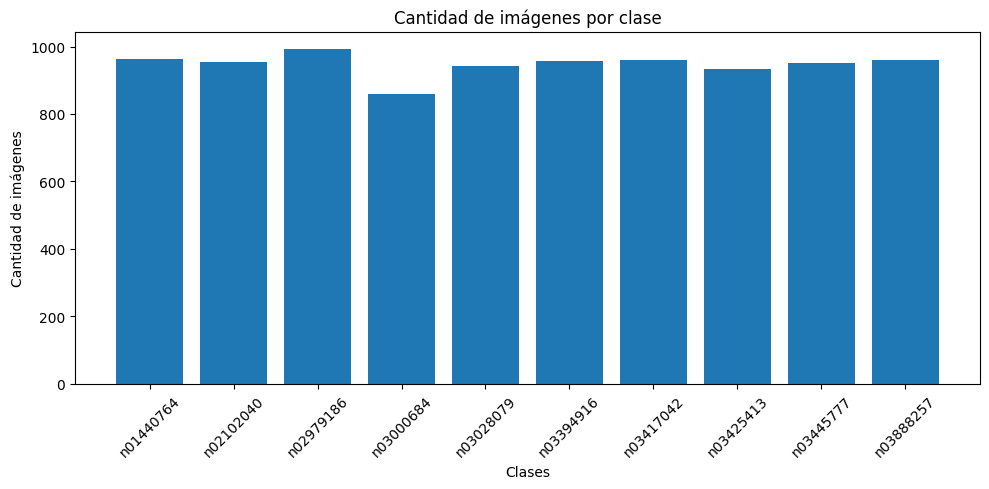

In [10]:
import matplotlib.pyplot as plt

# Ordenar clases para que el gráfico quede prolijo
sorted_classes = sorted(class_counts.keys())
sorted_counts = [class_counts[cls] for cls in sorted_classes]

plt.figure(figsize=(10, 5))
plt.bar(sorted_classes, sorted_counts)
plt.xticks(rotation=45)
plt.xlabel("Clases")
plt.ylabel("Cantidad de imágenes")
plt.title("Cantidad de imágenes por clase")
plt.tight_layout()
plt.show()


## Ver selección random de imágenes

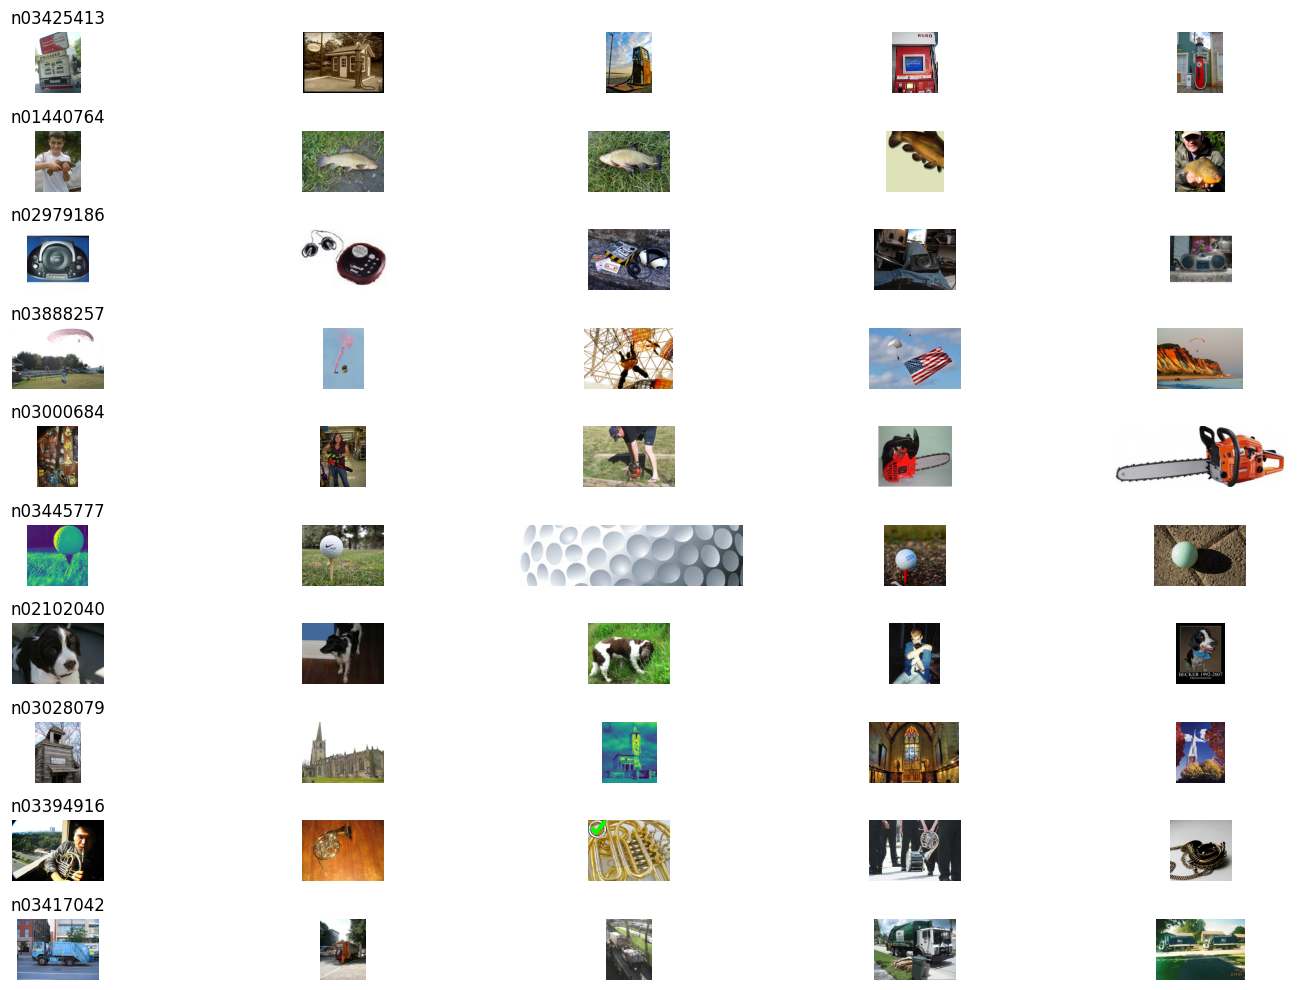

In [11]:
import random
import matplotlib.image as mpimg

n_samples = 5
fig, axs = plt.subplots(len(classes), n_samples, figsize=(15, 10))

for i, cls in enumerate(classes):
    img_files = os.listdir(os.path.join(root_dir, cls))
    for j in range(n_samples):
        img_path = os.path.join(root_dir, cls, random.choice(img_files))
        img = mpimg.imread(img_path)
        axs[i, j].imshow(img)
        axs[i, j].axis("off")
        if j == 0:
            axs[i, j].set_title(cls)
plt.tight_layout()
plt.show()


## Ver tamaños de imágenes

Se puede observar que el tamaño de las imágenes difiere mucho entre una y otra.

In [12]:
from PIL import Image

sizes = []
for cls in classes:
    img_files = os.listdir(os.path.join(root_dir, cls))
    for img_file in img_files[:50]:  # muestra
        img_path = os.path.join(root_dir, cls, img_file)
        with Image.open(img_path) as img:
            sizes.append(img.size)  # (ancho, alto)

size_counts = {}
for size in sizes:
    if size not in size_counts:
        size_counts[size] = 0
    size_counts[size] += 1

# Encontrar el tamaño más y menos común
most_common_size = None
most_common_count = -1
least_common_size = None
least_common_count = float('inf')

for size, count in size_counts.items():
    if count > most_common_count:
        most_common_size = size
        most_common_count = count
    if count < least_common_count:
        least_common_size = size
        least_common_count = count

print(f"\nTotal de tamaños diferentes encontrados: {len(size_counts)}")
print(f"Tamaño MÁS común: {most_common_size} (aparece {most_common_count} veces)")
print(f"Tamaño MENOS común: {least_common_size} (aparece {least_common_count} veces)")



Total de tamaños diferentes encontrados: 226
Tamaño MÁS común: (500, 375) (aparece 112 veces)
Tamaño MENOS común: (470, 500) (aparece 1 veces)


## Buscar duplicados

In [13]:
from pathlib import Path
import hashlib

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".gif", ".tif", ".tiff"}

def md5_file(path: Path):
    with path.open("rb") as f:
        return hashlib.md5(f.read()).hexdigest()

hashes = {}
duplicates = []

root = Path(root_dir)
for cls in classes:
    for path in (root/cls).iterdir():
        if not path.is_file() or path.suffix.lower() not in IMG_EXTS or path.name.startswith("."):
            continue
        h = md5_file(path)
        if h in hashes:
            duplicates.append((str(path), hashes[h]))
        else:
            hashes[h] = str(path)

print(f"Encontradas {len(duplicates)} imágenes duplicadas.")

Encontradas 0 imágenes duplicadas.


## Conclusión de la exploración de datos

Del análisis anterior podemos observar que las clases se encuentran balanceadas, ya que cada una posee un número similar de imágenes. Además, verificamos que no existen duplicados, por lo que no es necesario eliminar ninguna imagen. Finalmente, notamos que las imágenes presentan distintas dimensiones, por lo que es necesario aplicar un proceso de resize para garantizar la consistencia del conjunto de datos.

# Pruebas con transformaciones

Con el objetivo de entender qué transformaciones aplicar a las imagenes, para ayudar al modelo a interpretarlas mejor, hicimos las siguientes pruebas:

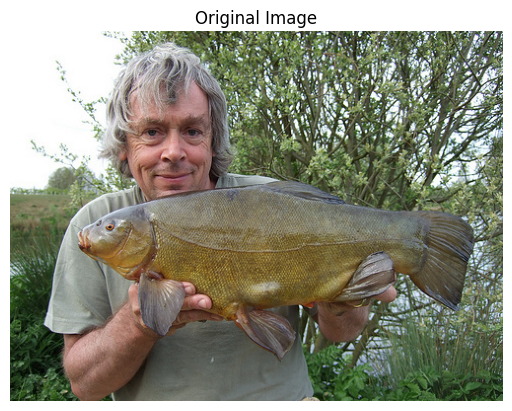

In [14]:
img = read_image(str(Path("data/imagenette2/train/n01440764/ILSVRC2012_val_00011993.JPEG")))
show_tensor_image(img, title="Original Image")

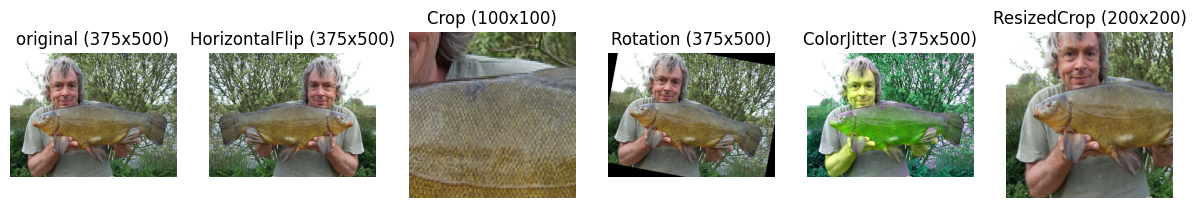

In [15]:
img_rhf = T.RandomHorizontalFlip(p=1)(img)  # p=1 para que siempre se aplique
img_rc = T.RandomCrop(size=(100, 100))(img)  # tomamos un recorte de 100x100
img_rr = T.RandomRotation(degrees=45)(
    img
)  # rotamos la imagen de forma aleatoria entre -45 y 45 grados
img_cj = T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)(
    img
)  # aplicamos un cambio de color
img_rrc = T.RandomResizedCrop(size=(200, 200))(
    img
)  # tomamos un recorte y redimensionamos a 200x200

show_tensor_images(
    [img, img_rhf, img_rc, img_rr, img_cj, img_rrc],
    titles=[
        f"original ({img.shape[-2]}x{img.shape[-1]})",
        f"HorizontalFlip ({img_rhf.shape[-2]}x{img_rhf.shape[-1]})",
        f"Crop ({img_rc.shape[-2]}x{img_rc.shape[-1]})",
        f"Rotation ({img_rr.shape[-2]}x{img_rr.shape[-1]})",
        f"ColorJitter ({img_cj.shape[-2]}x{img_cj.shape[-1]})",
        f"ResizedCrop ({img_rrc.shape[-2]}x{img_rrc.shape[-1]})",
    ],
)

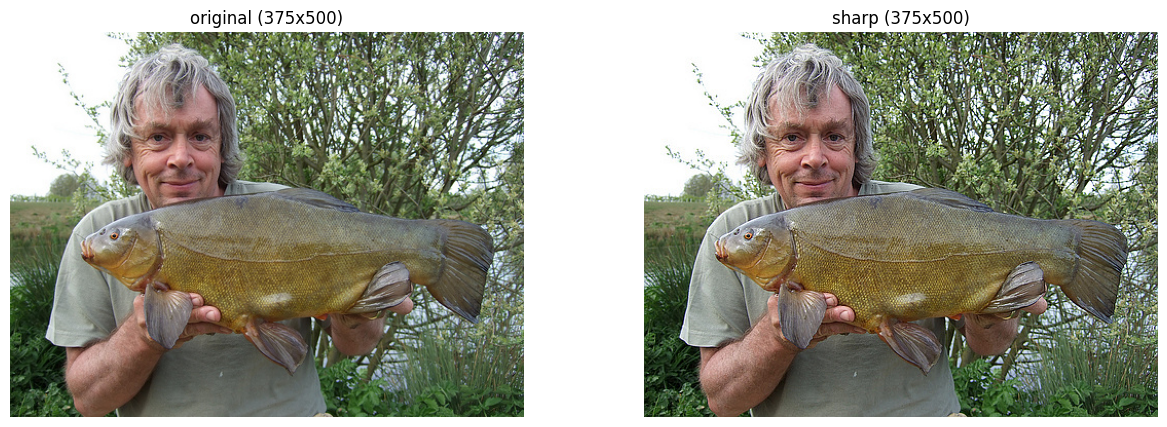

In [16]:
img_sharp = T.RandomAdjustSharpness(sharpness_factor=2.0, p=0.5)(img)
img_sharp = T.RandomEqualize(p=0.3)(img_sharp)
img_sharp = T.RandomAutocontrast(p=0.3)(img_sharp)

show_tensor_images(
    [img, img_sharp],
    titles=[
        f"original ({img.shape[-2]}x{img.shape[-1]})",
        f"sharp ({img_sharp.shape[-2]}x{img_sharp.shape[-1]})"
    ]
)

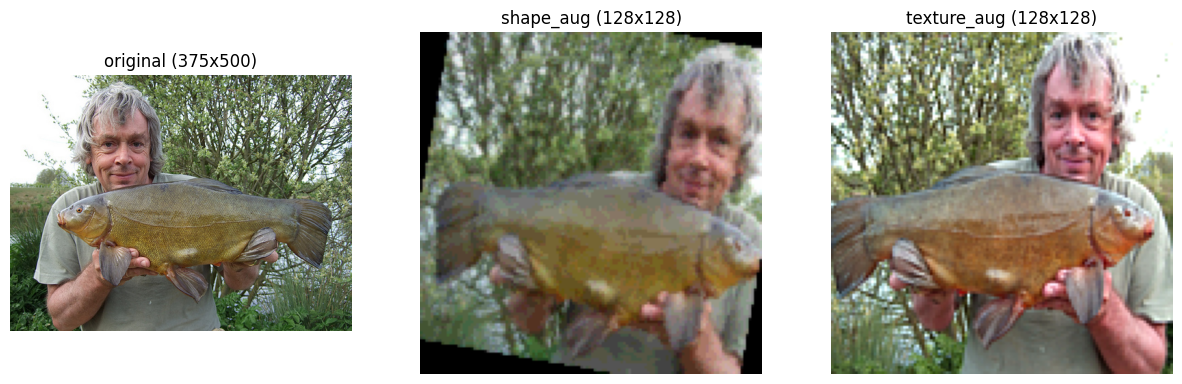

In [17]:
img_size_test = 128
# ---------- SHAPE ----------
img_shape = T.ToImage()(img)
# img_shape = T.Grayscale(num_output_channels=1)(img_shape)
img_shape = T.RandomHorizontalFlip(p=0.5)(img_shape)
img_shape = T.RandomResizedCrop(img_size_test, scale=(0.7, 1.0))(img_shape)
img_shape = T.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1))(img_shape)
img_shape = T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))(img_shape)   # suaviza textura
img_shape = T.RandomPosterize(bits=4, p=0.3)(img_shape)                   # reduce detalle
img_shape = T.RandomAutocontrast(p=0.3)(img_shape)
img_shape = T.ToDtype(torch.float32, scale=True)(img_shape)

# ---------- TEXTURE ----------
img_tex = T.ToImage()(img)                                               # mantiene RGB
img_tex = T.RandomResizedCrop(img_size_test, scale=(0.7, 1.0))(img_tex)
img_tex = T.RandomHorizontalFlip(p=0.5)(img_tex)
img_tex = T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05)(img_tex)
img_tex = T.RandomAdjustSharpness(sharpness_factor=2.0, p=0.5)(img_tex)   # realza bordes/tex
img_tex = T.RandomAutocontrast(p=0.3)(img_tex)
img_tex = T.ToDtype(torch.float32, scale=True)(img_tex)


show_tensor_images(
    [T.ToDtype(torch.float32, scale=True)(T.ToImage()(img)), img_shape, img_tex],
    titles=[
        f"original ({img.shape[-2]}x{img.shape[-1]})",
        f"shape_aug ({img_shape.shape[-2]}x{img_shape.shape[-1]})",
        f"texture_aug ({img_tex.shape[-2]}x{img_tex.shape[-1]})",
    ],
)


# LeNet

La primera red que probamos fue LeNet, con algunas modificaciones...

## Definiciones

In [18]:
DATA_DIR = Path("data")

# Wrapper para aplicar transformaciones
class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
    
    def __len__(self):
        return len(self.subset)
    
    def __getitem__(self, idx):
        image, label = self.subset[idx]
        return self.transform(image), label

def get_dataloaders(
    train_transf, test_transf, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS
):
    """
    Función para obtener los dataloaders de entrenamiento, validación y test

    Args:
    - train_transf: transformaciones para el dataset de entrenaiento
    - test_transf: transformaciones para el dataset de test
    - batch_size: tamaño del batch
    - num_workers: número de workers para cargar los datos
    """

    # descargamos el dataset
    train_dataset = datasets.Imagenette(
        DATA_DIR, split="train", download=True, transform=None
    ) 
    test_dataset = datasets.Imagenette(
        DATA_DIR, split="val", download=False, transform=test_transf
    )

    # dividimos el dataset de entrenamiento en entrenamiento y validación
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, validation_dataset = random_split(
        train_dataset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(SEED),  # fijamos la semilla
    )

    # aplicamos las transformaciones
    train_dataset = TransformDataset(train_dataset, train_transf)
    validation_dataset = TransformDataset(validation_dataset, test_transf)

    # creamos los dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
    )

    valid_loader = DataLoader(
        validation_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    return train_loader, valid_loader, test_loader

In [19]:
IMG_SIZE = 128  # Reducir tamaño de imagen para ahorrar memoria

In [20]:
val_tfms_lenet = T.Compose([
    T.ToImage(),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToDtype(torch.float32, scale=True),
])

In [21]:
train_dataset = datasets.Imagenette(
    DATA_DIR, split="train", download=False, transform=val_tfms_lenet
) 

data = torch.stack([img for img, _ in train_dataset])

# Calcula mean y std por canal
T_MEAN = data.mean(dim=[0, 2, 3])  # Promedia sobre samples, height, width
T_STD = data.std(dim=[0, 2, 3])

print(f"Mean: {T_MEAN}")
print(f"Std: {T_STD}")

Mean: tensor([0.4625, 0.4580, 0.4295])
Std: tensor([0.2769, 0.2730, 0.2967])


In [22]:
train_tfms_lenet = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=10),
    # Transformaciones comunes:
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.Normalize(mean=T_MEAN, std=T_STD),
])

val_tfms_lenet = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.Normalize(mean=T_MEAN, std=T_STD),
])


## Regularización

Aplicamos transformaciones sobre train, algunas de ellas para data augmentation, como ser RandomHorizontalFlip y RandomRotation. 

En el training loop aplicamos early stopping probando con distintos valores de paciencia y además agregamos una capa de dropout antes de la salida.

## Arquitectura del modelo

La arquitectura original de Lenet fue modificada para soportar imagenes de 3 canales.

Se agregó AdaptiveAvgPool2d((1,1)): ahora la salida conv se comprime a 1×1 sin importar el tamaño de entrada (más flexible).

Se cambió Linear(120, 84) por LazyLinear(84): la red infiere automáticamente cuántas features entran a la capa densa (evita recalcular a mano)

Consecuencia: la versión nueva (flexible) soporta entradas que no sean 32×32 y cambios en kernels/strides sin romper dimensiones; la LeNet clásica asume 32×32 y que el último conv termine en 1×1.

In [23]:
class LeNet(nn.Module):
    def __init__(self, in_channels, num_classes, use_dropout=False, dropout_p=0.5):
        super(LeNet, self).__init__()
        self.use_dropout = use_dropout
        self.dropout_p = dropout_p

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1, padding=0)  
        self.pool  = nn.AvgPool2d(kernel_size=2, stride=2)                                                   # /2
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)           
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1, padding=0)        
        self.pool3 = nn.AdaptiveAvgPool2d((1, 1))  # reemplaza al AvgPool2d(28,28)

        self.tanh = nn.Tanh()
        self.linear = nn.LazyLinear(84)   # en vez de nn.Linear(120, 84)

        self.output = nn.Linear(84, num_classes)
        self.flatten = nn.Flatten(start_dim=1)
        self.dropout = nn.Dropout(p=self.dropout_p) if self.use_dropout else nn.Identity()

    def forward(self, x):
        x = self.tanh(self.conv1(x))
        x = self.pool(x) 
        x = self.tanh(self.conv2(x)) 
        x = self.pool(x)             
        x = self.tanh(self.conv3(x)) 
        x = self.pool3(x)            
        x = self.flatten(x)          
        x = self.tanh(self.linear(x))
        x = self.dropout(x)
        x = self.output(x)           
        return x


summary(LeNet(3, NUM_CLASES), input_size=(BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [32, 10]                  --
├─Conv2d: 1-1                            [32, 6, 124, 124]         456
├─Tanh: 1-2                              [32, 6, 124, 124]         --
├─AvgPool2d: 1-3                         [32, 6, 62, 62]           --
├─Conv2d: 1-4                            [32, 16, 58, 58]          2,416
├─Tanh: 1-5                              [32, 16, 58, 58]          --
├─AvgPool2d: 1-6                         [32, 16, 29, 29]          --
├─Conv2d: 1-7                            [32, 120, 25, 25]         48,120
├─Tanh: 1-8                              [32, 120, 25, 25]         --
├─AdaptiveAvgPool2d: 1-9                 [32, 120, 1, 1]           --
├─Flatten: 1-10                          [32, 120]                 --
├─Linear: 1-11                           [32, 84]                  10,164
├─Tanh: 1-12                             [32, 84]                  --
├─I

## Entrenamiento


In [24]:
LR = 0.001
EPOCHS = 100
criterion = nn.CrossEntropyLoss().to(DEVICE)

In [25]:
letnet_model = LeNet(3, NUM_CLASES).to(DEVICE)
optimizer = optim.Adam(letnet_model.parameters(), lr=LR)

train_loader, val_loader, test_loader = get_dataloaders(train_tfms_lenet, val_tfms_lenet, BATCH_SIZE, NUM_WORKERS)


epoch_train_errors, epoch_val_errors = train(
    letnet_model,
    optimizer,
    criterion,
    train_loader,
    val_loader,
    DEVICE,
    do_early_stopping=True,
    patience=5,
    epochs=EPOCHS,
    log_fn=print_log,
    log_every=1,
)

Epoch: 001 | Train Loss: 2.09092 | Val Loss: 1.99548
Epoch: 002 | Train Loss: 1.95193 | Val Loss: 1.89627
Epoch: 003 | Train Loss: 1.89158 | Val Loss: 1.82943
Epoch: 004 | Train Loss: 1.84299 | Val Loss: 1.82863
Epoch: 005 | Train Loss: 1.79019 | Val Loss: 1.74160
Epoch: 006 | Train Loss: 1.74906 | Val Loss: 1.70639
Epoch: 007 | Train Loss: 1.70383 | Val Loss: 1.61568
Epoch: 008 | Train Loss: 1.66154 | Val Loss: 1.60141
Epoch: 009 | Train Loss: 1.62034 | Val Loss: 1.56524
Epoch: 010 | Train Loss: 1.58046 | Val Loss: 1.51784
Epoch: 011 | Train Loss: 1.55113 | Val Loss: 1.49289
Epoch: 012 | Train Loss: 1.52182 | Val Loss: 1.47147
Epoch: 013 | Train Loss: 1.48239 | Val Loss: 1.46581
Epoch: 014 | Train Loss: 1.45291 | Val Loss: 1.46791
Epoch: 015 | Train Loss: 1.44418 | Val Loss: 1.40952
Epoch: 016 | Train Loss: 1.41019 | Val Loss: 1.36553
Epoch: 017 | Train Loss: 1.38576 | Val Loss: 1.38616
Epoch: 018 | Train Loss: 1.35364 | Val Loss: 1.40144
Epoch: 019 | Train Loss: 1.33660 | Val Loss: 1

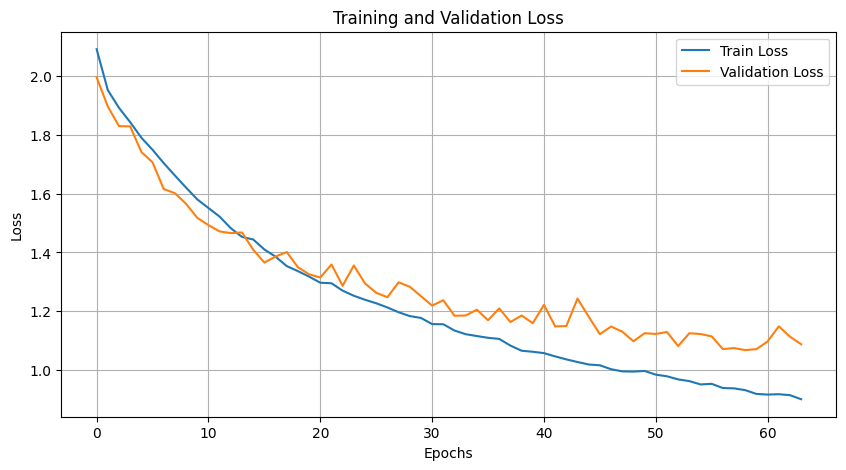

In [27]:
plot_training(epoch_train_errors, epoch_val_errors)

In [28]:
model_classification_report(letnet_model, val_loader, DEVICE, NUM_CLASES)

Accuracy: 0.6403

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.72      0.81      0.76       187
           1       0.67      0.61      0.64       196
           2       0.65      0.64      0.64       212
           3       0.73      0.22      0.33       171
           4       0.63      0.63      0.63       186
           5       0.55      0.67      0.60       180
           6       0.68      0.68      0.68       197
           7       0.54      0.61      0.57       193
           8       0.56      0.74      0.64       190
           9       0.81      0.77      0.79       184

    accuracy                           0.64      1896
   macro avg       0.65      0.64      0.63      1896
weighted avg       0.65      0.64      0.63      1896



## Weight & Biases

En wandb probamos variar distintos parámetros del problema para luego ver qué combinación nos da el mejor resultado.

Para la métrica elegimos accuracy porque entendemos que es la más útil para este problema, teniendo en cuenta que las clases están bien balanceadas.

In [29]:
WANDB_TEAM_NAME = "mc-ort"
WANDB_PROJECT = "Tarea1_LeNet_3"
os.environ["WANDB_NOTEBOOK_NAME"] = "./Tarea_1_letra.ipynb"

wandb.login()

wandb: Currently logged in as: mc241319 (mc-ort) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [30]:
sweep_config = {
    "name": "tarea_1_lenet_3",
    "method": "random",
    "metric": {"name": "val_accuracy", "goal": "maximize"},  
    "parameters": {
        # Optimizador y LR
        "optimizer": {"values": ["adam", "sgd"]},
        "learning_rate": {"distribution": "log_uniform_values", "min": 1e-4, "max": 5e-3},
        "weight_decay": {"values": [0.0, 1e-4, 5e-4]},

        # Regularización en FC
        "dropout_p": {"values": [0.0, 0.2, 0.3]},

        # Data 
        "batch_size": {"values": [32, 64, 128]},

        # Early stopping
        "early_stop": {"values": [True, False]},
        "patience": {"values": [4, 6]},   

        # Entrenamiento                
        "label_smoothing": {"values": [0.0, 0.05]},
    },
}

sweep_id = wandb.sweep(sweep_config, project=WANDB_PROJECT)

Create sweep with ID: dc0qn2rm
Sweep URL: https://wandb.ai/mc-ort/Tarea1_LeNet_3/sweeps/dc0qn2rm


In [31]:
entity = wandb.api.default_entity
project = WANDB_PROJECT

In [32]:
def wand_log(epoch, train_loss, val_loss):
    wandb.log({"epoch": epoch + 1, "train_loss": train_loss, "val_loss": val_loss})


In [33]:
def sweep_run():
    """
    Función que se ejecutará en cada run del sweep.
    """
    # inicializar un nuevo run
    wandb.init()
    
    # leer la configuración del run
    config = wandb.config
    run_learning_rate = config.learning_rate
    run_optimizer = config.optimizer
    run_weight_decay = config.weight_decay
    run_dropout_p = config.dropout_p
    run_batch_size = config.batch_size
    run_early_stopping = config.early_stop
    run_patience = config.patience
    run_label_smoothing = config.label_smoothing

    # modelo
    if run_dropout_p == 0:
        model = LeNet(3, NUM_CLASES).to(DEVICE)
    else:
        model = LeNet(3, NUM_CLASES, True, run_dropout_p).to(DEVICE)

    # dataloaders  
    train_loader, val_loader, test_loader = get_dataloaders(train_tfms_lenet, val_tfms_lenet, run_batch_size, NUM_WORKERS)

    # optimizer
    if run_optimizer == "adam":
      optimizer = optim.Adam(model.parameters(), lr=run_learning_rate, weight_decay=run_weight_decay)
    elif run_optimizer == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=run_learning_rate, momentum=0.9, nesterov=True, weight_decay=run_weight_decay)

    # criterion
    if run_label_smoothing == 0:
        criterion = nn.CrossEntropyLoss().to(DEVICE)
    else:
        criterion = nn.CrossEntropyLoss(label_smoothing=run_label_smoothing).to(DEVICE)

    def log_with_timing(epoch, train_loss, val_loss):
        if (epoch + 1) % 10 == 0 or (epoch + 1) == 1:
            wandb.log({"epoch": epoch+1, "train_loss": train_loss, "val_loss": val_loss})
            print(f"[EPOCH {epoch+1}] train_loss={train_loss:.4f} val_loss={val_loss:.4f}", flush=True)        

    train(model, optimizer, criterion, train_loader, val_loader, device=DEVICE, do_early_stopping=run_early_stopping, patience=run_patience,
          epochs=EPOCHS, log_fn=log_with_timing, log_every=1)
    
    # guardo pesos temporalmente
    torch.save(model.state_dict(), "letnet_model.pth")
    wandb.save(f"letnet_model.pth")

    wandb.finish()

In [34]:
wandb.agent(sweep_id, function=sweep_run, count=3) 

wandb: Agent Starting Run: pogn5uh5 with config:
wandb: 	batch_size: 32
wandb: 	dropout_p: 0
wandb: 	early_stop: False
wandb: 	label_smoothing: 0
wandb: 	learning_rate: 0.0005320724609938262
wandb: 	optimizer: adam
wandb: 	patience: 6
wandb: 	weight_decay: 0


[EPOCH 1] train_loss=2.1113 val_loss=2.0077
[EPOCH 10] train_loss=1.6867 val_loss=1.6632
[EPOCH 20] train_loss=1.4807 val_loss=1.4840
[EPOCH 30] train_loss=1.3383 val_loss=1.3549
[EPOCH 40] train_loss=1.2422 val_loss=1.2922
[EPOCH 50] train_loss=1.1536 val_loss=1.2417
[EPOCH 60] train_loss=1.0725 val_loss=1.1959
[EPOCH 70] train_loss=1.0329 val_loss=1.1365
[EPOCH 80] train_loss=0.9706 val_loss=1.1434
[EPOCH 90] train_loss=0.9326 val_loss=1.1040
[EPOCH 100] train_loss=0.9028 val_loss=1.0892


wandb: Agent Starting Run: 4gu6y1oa with config:
wandb: 	batch_size: 128
wandb: 	dropout_p: 0
wandb: 	early_stop: True
wandb: 	label_smoothing: 0.05
wandb: 	learning_rate: 0.00011547434322574016
wandb: 	optimizer: sgd
wandb: 	patience: 6
wandb: 	weight_decay: 0.0001


[EPOCH 1] train_loss=2.3096 val_loss=2.3105
[EPOCH 10] train_loss=2.3026 val_loss=2.3030
[EPOCH 20] train_loss=2.2926 val_loss=2.2927
[EPOCH 30] train_loss=2.2742 val_loss=2.2728
[EPOCH 40] train_loss=2.2439 val_loss=2.2422
[EPOCH 50] train_loss=2.2174 val_loss=2.2156
[EPOCH 70] train_loss=2.1897 val_loss=2.1893
[EPOCH 80] train_loss=2.1813 val_loss=2.1802
[EPOCH 90] train_loss=2.1721 val_loss=2.1729
[EPOCH 100] train_loss=2.1654 val_loss=2.1669


wandb: Agent Starting Run: pcrznswa with config:
wandb: 	batch_size: 32
wandb: 	dropout_p: 0
wandb: 	early_stop: True
wandb: 	label_smoothing: 0.05
wandb: 	learning_rate: 0.0015346388936760735
wandb: 	optimizer: adam
wandb: 	patience: 4
wandb: 	weight_decay: 0.0001


[EPOCH 1] train_loss=2.1007 val_loss=2.1133
[EPOCH 10] train_loss=1.6371 val_loss=1.5957
[EPOCH 20] train_loss=1.4212 val_loss=1.4295
Detener entrenamiento en la época 22, la mejor pérdida fue 1.41103


## Evaluación final tomando mejor modelo

In [37]:
api = wandb.Api()

ENTITY = api.default_entity
sweep = api.sweep(f"{ENTITY}/{WANDB_PROJECT}/{sweep_id}")

# obtenemos el mejor run
lenet_best_run = sweep.best_run()

# imprimimos el mejor run
print("best run:", lenet_best_run)
print("Best run name:", lenet_best_run.name)
print("Best run name:", lenet_best_run.id)
print("Best run config:", lenet_best_run.config)

# descargamos el modelo del mejor run
lenet_best_run.file("letnet_model.pth").download(replace=True)

wandb: Sorting runs by -summary_metrics.val_accuracy


best run: <Run mc-ort/Tarea1_LeNet_3/4gu6y1oa (finished)>
Best run name: logical-sweep-2
Best run name: 4gu6y1oa
Best run config: {'patience': 6, 'dropout_p': 0, 'optimizer': 'sgd', 'batch_size': 128, 'early_stop': True, 'weight_decay': 0.0001, 'learning_rate': 0.00011547434322574016, 'label_smoothing': 0.05}


<_io.TextIOWrapper name='./letnet_model.pth' mode='r' encoding='UTF-8'>

In [38]:
# restauramos el modelo
letnet_model.load_state_dict(torch.load("letnet_model.pth"))

<All keys matched successfully>

In [38]:
criterion = nn.CrossEntropyLoss().to(DEVICE)

# Evaluamos el modelo en el conjunto de test
test_loss = evaluate(letnet_model, criterion, test_loader, DEVICE) 

print(f"Test Loss: {test_loss:.5f}")

Test Loss: 1.12989


In [39]:
model_classification_report(letnet_model, test_loader, DEVICE, NUM_CLASES)

Accuracy: 0.6497

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.71      0.83      0.77       387
           1       0.71      0.68      0.70       395
           2       0.60      0.71      0.65       357
           3       0.70      0.20      0.31       386
           4       0.69      0.68      0.69       409
           5       0.59      0.64      0.62       394
           6       0.67      0.69      0.68       389
           7       0.55      0.60      0.57       419
           8       0.56      0.75      0.64       399
           9       0.80      0.72      0.76       390

    accuracy                           0.65      3925
   macro avg       0.66      0.65      0.64      3925
weighted avg       0.66      0.65      0.64      3925



## Conclusión de los datos

# DenseNet


## Definiciones

In [42]:
IMG_SIZE = 128 # image size lo mas grande posible para tener mas resolucion
BATCH_SIZE = 32

## Arquitectura

In [43]:
class DenseLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DenseLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        y = self.conv(self.relu(self.bn(x)))
        return torch.cat([x,y] , dim=1)

In [44]:
class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        self.block = []
        for i in range(num_layers):
            self.block += [DenseLayer(in_channels + i * growth_rate, growth_rate)]
        self.denseBlock = nn.Sequential(*self.block)
        

    def forward(self, x):
       return self.denseBlock(x)

In [ ]:
class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True) #optional
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(self.relu(self.bn(x))) #relu es opcional
        return self.pool(x)

La arquitectura de DenseNet es igual a la original pero agregando una capa de dropout.

In [46]:
class DenseNet(nn.Module):
    def __init__(self, num_layers = [6, 12, 24, 16], growth_rate=32, num_classes=10, dropout_p=0.0):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate
        self.num_layers = num_layers
        self.num_blocks = len(num_layers)
        self.dropout_p = dropout_p

        # Capa inicial: se encarga de extraer características iniciales
        current_channels = 3
        self.convI = nn.Conv2d(current_channels, 2*growth_rate, kernel_size=3, padding=1)
        current_channels = 2*growth_rate
        self.poolI = nn.MaxPool2d(2, 2)
        self.bnI = nn.BatchNorm2d(current_channels)
        self.relu = nn.ReLU(True)

        dense_blocks = []
        # Bloques densos y capas de transición en nn.Sequential
        for i in range(self.num_blocks):
            current_layers = num_layers[i]
            dense_blocks += [DenseBlock(current_layers, current_channels, growth_rate)]
            current_channels += current_layers * growth_rate
            if i < self.num_blocks - 1:
                dense_blocks += [TransitionLayer(current_channels, current_channels // 2)]
                current_channels = current_channels // 2
        self.dense_blocks = nn.Sequential(*dense_blocks)

        # Capa de clasificación con dropout
        self.avgPool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten(start_dim=1)
        self.dropout = nn.Dropout(p=dropout_p) if dropout_p > 0 else nn.Identity()
        self.classifier = nn.Linear(current_channels, num_classes)
        

    def forward(self, x):
        x = self.relu(self.bnI(self.convI(x)))
        x = self.dense_blocks(x)
        x = self.avgPool(x)
        x = self.flatten(x)
        x = self.dropout(x)  # Aplicar dropout antes de la capa final
        x = self.classifier(x)
        return x


# Ejemplo de uso
densenet_example = DenseNet(num_layers=[6, 12, 24, 16], growth_rate=32, num_classes=10)

summary(densenet_example, input_size=(BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE), depth=3)

Layer (type:depth-idx)                        Output Shape              Param #
DenseNet                                      [32, 10]                  --
├─Conv2d: 1-1                                 [32, 64, 128, 128]        1,792
├─BatchNorm2d: 1-2                            [32, 64, 128, 128]        128
├─ReLU: 1-3                                   [32, 64, 128, 128]        --
├─Sequential: 1-4                             [32, 1024, 16, 16]        --
│    └─DenseBlock: 2-1                        [32, 256, 128, 128]       --
│    │    └─Sequential: 3-1                   [32, 256, 128, 128]       250,752
│    └─TransitionLayer: 2-2                   [32, 128, 64, 64]         --
│    │    └─BatchNorm2d: 3-2                  [32, 256, 128, 128]       512
│    │    └─ReLU: 3-3                         [32, 256, 128, 128]       --
│    │    └─Conv2d: 3-4                       [32, 128, 128, 128]       32,896
│    │    └─AvgPool2d: 3-5                    [32, 128, 64, 64]         --
│    └

## Carga de datos con transforms

La idea de estas transformaciones es evaluar si el modelo funciona mejor cuando reforzamos las texturas y/o las formas en la imagen, ya que leimos en un paper (https://arxiv.org/pdf/1811.12231) que al entrenar CNNs con ImageNet, estos modelos podían tener un sesgo hacia las texturas.

La función get_train_tfms_densenet fue definida para facilitar la elección de una u otra transformación en las pruebas de wandb.

In [47]:
def get_train_tfms_densenet(image_size=IMG_SIZE, transform_shape=True, transform_texture=True):
    transforms = [
        T.ToImage(),
        T.ToDtype(torch.float32, scale=True),
        T.Resize((image_size, image_size), antialias=True),

        # Geométricas
        T.RandomHorizontalFlip(p=0.5),
        T.RandomRotation(degrees=10),
        T.RandomResizedCrop((image_size, image_size), scale=(0.8, 1.0), antialias=True),
        T.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),

        T.RandomAutocontrast(p=0.3)
    ]
   
    if transform_shape:
        transforms += [
            T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
            T.RandomEqualize(p=0.3),
            T.RandomPosterize(bits=4, p=0.3)
        ]
        
    if transform_texture: 
        transforms += [
            T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
            T.RandomAdjustSharpness(sharpness_factor=2.0, p=0.5)
           
        ]
    
    
    transforms += [
        T.Normalize(mean=T_MEAN, std=T_STD),
    ]

    train_transforms = T.Compose(transforms)
    
    val_transforms = T.Compose([
        T.ToImage(),
        T.ToDtype(torch.float32, scale=True),
        T.Resize((image_size, image_size), antialias=True),
        T.Normalize(mean=T_MEAN, std=T_STD),
    ])
    
    return train_transforms, val_transforms


In [48]:
densenet_model = DenseNet(
    num_layers=[6, 12, 24, 16], growth_rate=12, num_classes=10
).to(DEVICE)

optimizer = optim.Adam(densenet_model.parameters(), lr=LR)

CRITERION = nn.CrossEntropyLoss().to(DEVICE)

In [49]:
train_errors_dn, val_errors_dn = train(
    model=densenet_model,
    optimizer=optimizer,
    criterion=CRITERION,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    do_early_stopping=True,
    patience=8,
    epochs=EPOCHS,
)

Epoch: 001 | Train Loss: 1.98479 | Val Loss: 1.79869
Epoch: 002 | Train Loss: 1.68089 | Val Loss: 1.77201
Epoch: 003 | Train Loss: 1.51620 | Val Loss: 1.39621
Epoch: 004 | Train Loss: 1.41175 | Val Loss: 1.38727
Epoch: 005 | Train Loss: 1.32265 | Val Loss: 1.36812
Epoch: 006 | Train Loss: 1.23457 | Val Loss: 1.32800
Epoch: 007 | Train Loss: 1.16457 | Val Loss: 1.26586
Epoch: 008 | Train Loss: 1.08760 | Val Loss: 1.23591
Epoch: 009 | Train Loss: 1.02374 | Val Loss: 1.01957
Epoch: 010 | Train Loss: 0.97417 | Val Loss: 1.52564
Epoch: 011 | Train Loss: 0.93277 | Val Loss: 1.07944
Epoch: 012 | Train Loss: 0.89160 | Val Loss: 1.06030
Epoch: 013 | Train Loss: 0.85782 | Val Loss: 0.93469
Epoch: 014 | Train Loss: 0.80855 | Val Loss: 0.87899
Epoch: 015 | Train Loss: 0.75974 | Val Loss: 0.88218
Epoch: 016 | Train Loss: 0.73357 | Val Loss: 0.79287
Epoch: 017 | Train Loss: 0.74418 | Val Loss: 0.78134
Epoch: 018 | Train Loss: 0.67480 | Val Loss: 0.92101
Epoch: 019 | Train Loss: 0.66937 | Val Loss: 1

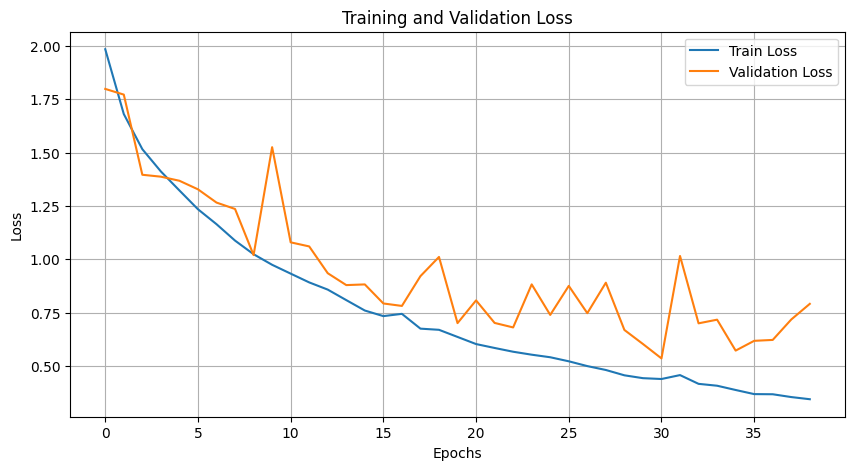

In [50]:
plot_training(train_errors_dn, val_errors_dn)

In [51]:
model_classification_report(densenet_model, test_loader, DEVICE, NUM_CLASES)

Accuracy: 0.7442

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.86      0.89      0.88       387
           1       0.98      0.61      0.76       395
           2       0.67      0.82      0.74       357
           3       0.57      0.49      0.53       386
           4       0.82      0.85      0.84       409
           5       0.96      0.49      0.65       394
           6       0.59      0.93      0.72       389
           7       0.71      0.66      0.68       419
           8       0.68      0.89      0.77       399
           9       0.89      0.81      0.85       390

    accuracy                           0.74      3925
   macro avg       0.77      0.74      0.74      3925
weighted avg       0.77      0.74      0.74      3925



(0.7442038216560509,
 0.7731717250323571,
 0.7449141319406817,
 0.7406757400429816,
 3925.0)

## Entrenamiento DenseNet con cosine decay

Definimos la función train_cosine_decay, que es igual a la train que venimos usando, pero agrega cosine decay para manejar el valor del learning rate.
Lo que hace esto es ajustar el learning rate schedule para mejorar la convergencia. La idea es probar en Weight and Bias si el modelo converge más rápido y si trae alguna otra mejora, al tomar learning rate de esta manera.

En esta sección probamos una corrida manual para verificar que el resultado no empeore.


In [54]:
from torch.optim.lr_scheduler import CosineAnnealingLR

def train_cosine_decay(
    model,
    optimizer,
    criterion,
    train_loader,
    val_loader,
    device,
    do_early_stopping=True,
    patience=5,
    epochs=10,
    log_fn=print_log,
    log_every=1,
    eta_min=1e-6,
):
    """
    Entrena el modelo utilizando Cosine Decay (CosineAnnealingLR) para el learning rate.
    """

    epoch_train_errors = []
    epoch_val_errors = []

    if do_early_stopping:
        early_stopping = EarlyStopping(patience=patience)

    # Scheduler Cosine Decay
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=eta_min)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            
            output = model(x)
            batch_loss = criterion(output, y)
            
            batch_loss.backward()
            optimizer.step()

            train_loss += batch_loss.item()

        train_loss /= len(train_loader)
        epoch_train_errors.append(train_loss)

        val_loss = evaluate(model, criterion, val_loader, device)
        epoch_val_errors.append(val_loss)

        # Step del scheduler (una vez por epoch)
        scheduler.step()
        current_lr = scheduler.get_last_lr()[0]

        if do_early_stopping:
            early_stopping(val_loss)

        if log_fn is not None and (epoch + 1) % log_every == 0:
            log_fn(epoch, train_loss, val_loss)

        if do_early_stopping and early_stopping.early_stop:
            print(f"⏹ Detener entrenamiento en la época {epoch+1}, mejor val_loss={early_stopping.best_score:.5f}")
            break

    return epoch_train_errors, epoch_val_errors


In [55]:
densenet_cosinedecay_model = DenseNet(
    num_layers=[6, 12, 24, 16], growth_rate=12, num_classes=10
).to(DEVICE)

optimizer = optim.Adam(densenet_cosinedecay_model.parameters(), lr=LR)

train_errors_dn, val_errors_dn = train_cosine_decay(
    model=densenet_cosinedecay_model,
    optimizer=optimizer,
    criterion=CRITERION,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    do_early_stopping=True,
    patience=8,
    epochs=EPOCHS,
)

Epoch: 001 | Train Loss: 1.97422 | Val Loss: 1.83150
Epoch: 002 | Train Loss: 1.68714 | Val Loss: 1.49615
Epoch: 003 | Train Loss: 1.50084 | Val Loss: 1.61483
Epoch: 004 | Train Loss: 1.38134 | Val Loss: 1.60401
Epoch: 005 | Train Loss: 1.28923 | Val Loss: 1.41968
Epoch: 006 | Train Loss: 1.17602 | Val Loss: 1.26016
Epoch: 007 | Train Loss: 1.13106 | Val Loss: 1.15928
Epoch: 008 | Train Loss: 1.05340 | Val Loss: 1.04460
Epoch: 009 | Train Loss: 1.01098 | Val Loss: 1.11977
Epoch: 010 | Train Loss: 0.94136 | Val Loss: 0.98729
Epoch: 011 | Train Loss: 0.90054 | Val Loss: 1.24952
Epoch: 012 | Train Loss: 0.88488 | Val Loss: 0.80903
Epoch: 013 | Train Loss: 0.83663 | Val Loss: 0.96078
Epoch: 014 | Train Loss: 0.81030 | Val Loss: 0.75156
Epoch: 015 | Train Loss: 0.73565 | Val Loss: 0.74617
Epoch: 016 | Train Loss: 0.73202 | Val Loss: 0.89129
Epoch: 017 | Train Loss: 0.70372 | Val Loss: 0.79248
Epoch: 018 | Train Loss: 0.68343 | Val Loss: 0.70937
Epoch: 019 | Train Loss: 0.63845 | Val Loss: 0

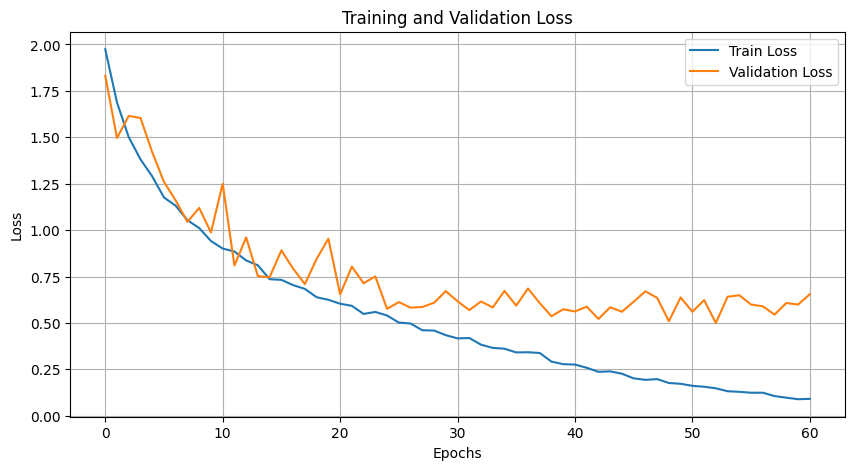

In [56]:
plot_training(train_errors_dn, val_errors_dn)

In [57]:
model_classification_report(densenet_cosinedecay_model, test_loader, DEVICE, NUM_CLASES)

Accuracy: 0.8617

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92       387
           1       0.96      0.91      0.93       395
           2       0.85      0.80      0.83       357
           3       0.72      0.80      0.76       386
           4       0.94      0.88      0.91       409
           5       0.88      0.82      0.85       394
           6       0.83      0.89      0.86       389
           7       0.78      0.82      0.80       419
           8       0.89      0.88      0.89       399
           9       0.90      0.87      0.89       390

    accuracy                           0.86      3925
   macro avg       0.86      0.86      0.86      3925
weighted avg       0.86      0.86      0.86      3925



(0.861656050955414,
 0.8647864684331624,
 0.8613067733356546,
 0.862291467895458,
 3925.0)

### Conclusión sobre prueba con cosine_decay

 SEGUN LO QUE PONGAMOS ACA, ES LO QUE FIJAMOS EN WANDB, NO VAMOS A TESTEAR TANTO LR.

## Weight & Biases

A los parámetros habituales del sweep agregamos:

- growth_rate          --> modificamos cuánta información pasa de una capa a la otra
- num_layers           --> queremos comparar entre redes "chicas" y "grandes", cuál da mejor resultado
- use_cosine_annealing --> True para cosine decay, False para tomar learning rate de log_uniform_values
- cosine_eta_min       --> Valor mas bajo que alcanza el LR sobre el final del entrenamiento
- transform_shape      --> Si es True, aplica transforms a train que resaltan las formas en la imagen
- transform_texture    --> Si es True, aplica transforms a train que realtan la textura de la imagen

Hicimos distintas pruebas y notamos que variando tantos parámetros demoraba mucho en correr y no siempre probaba todas las combinaciones que nos interesaban => dividimos las corridas de wandb para ir seleccionando los parámetros en tandas.

### Weight & Biases (I)

In [58]:
# Sweep configuration for DenseNet
sweep_config_densenet = {
    "name": "tarea_1_densenet_sweep",
    "method": "random",
    "metric": {"name": "val_accuracy", "goal": "maximize"},
    "parameters": {
        # Optimizer and learning parameters
        "optimizer": {"values": ["adam", "sgd"]},
        "learning_rate": {"distribution": "log_uniform_values", "min": 1e-4, "max": 5e-3},
        "weight_decay": {"values": [0.0, 1e-4, 1e-3]},
        
        # Training parameters
        "batch_size": {"values": [16, 32]},
        "early_stop": {"values": [True, False]},
        "patience": {"values": [5, 10, 15]},
        "label_smoothing": {"values": [0.0, 0.05, 0.1]},
        
        # DenseNet specific parameters
        "growth_rate": {"values": [16, 24, 32]},
        "num_layers": {
            "values": [
                [4, 6, 8, 6],     # Smaller version
                [6, 12, 24, 16],  # DenseNet-121 original
                [6, 12, 32, 32],  # DenseNet-169 style
            ]
        },
        
        # Scheduler options
        "use_cosine_annealing": {"values": [True, False]},
        "cosine_eta_min": {"values": [1e-5, 1e-4]},
        
        # Regularization
        "dropout_p": {"values": [0.0, 0.1, 0.3]},
        "transform_shape": {"values": [True, False]},
        "transform_texture": {"values": [True, False]},
    },
}

DenseNet Sweep Configuration:
Total parameter combinations: 14 parameters
  optimizer: 2 options
  learning_rate: log_uniform_values distribution
  weight_decay: 4 options
  batch_size: 2 options
  early_stop: 2 options
  patience: 4 options
  label_smoothing: 3 options
  growth_rate: 3 options
  num_layers: 3 options
  use_cosine_annealing: 2 options
  cosine_eta_min: 3 options
  dropout_p: 4 options
  transform_shape: 2 options
  transform_texture: 2 options


In [61]:
def densenet_sweep_run():
    """
    Función que se ejecutará en cada run del sweep para DenseNet.
    """
    # Inicializar un nuevo run
    wandb.init()
    
    # Leer la configuración del run
    config = wandb.config
    run_learning_rate = config.learning_rate
    run_optimizer = config.optimizer
    run_weight_decay = config.weight_decay
    run_batch_size = config.batch_size
    run_early_stopping = config.early_stop
    run_patience = config.patience
    run_label_smoothing = config.label_smoothing
    run_growth_rate = config.growth_rate
    run_num_layers = config.num_layers
    run_use_cosine_annealing = config.use_cosine_annealing
    run_cosine_eta_min = config.cosine_eta_min
    run_dropout_p = config.dropout_p
    run_transform_shape = config.transform_shape
    run_transform_texture = config.transform_texture

    # Crear modelo DenseNet
    model = DenseNet(
        num_layers=run_num_layers,
        growth_rate=run_growth_rate,
        num_classes=NUM_CLASES,
        dropout_p=run_dropout_p
    ).to(DEVICE)

    # Crear dataloaders
    train_tfms_densenet, val_tfms_densenet = get_train_tfms_densenet(64, run_transform_shape, run_transform_texture)
    train_loader, val_loader, test_loader = get_dataloaders(
        train_tfms_densenet, val_tfms_densenet, run_batch_size, NUM_WORKERS
    )

    # Crear optimizer
    if run_optimizer == "adam":
        optimizer = optim.Adam(
            model.parameters(), 
            lr=run_learning_rate, 
            weight_decay=run_weight_decay
        )
    elif run_optimizer == "sgd":
        optimizer = optim.SGD(
            model.parameters(), 
            lr=run_learning_rate, 
            momentum=0.9, 
            nesterov=True, 
            weight_decay=run_weight_decay
        )

    # Crear criterion
    if run_label_smoothing == 0:
        criterion = nn.CrossEntropyLoss().to(DEVICE)
    else:
        criterion = nn.CrossEntropyLoss(label_smoothing=run_label_smoothing).to(DEVICE)

    def log_with_timing(epoch, train_loss, val_loss):
        if (epoch + 1) % 5 == 0:  # Log cada 5 épocas
            wandb.log({
                "epoch": epoch+1, 
                "train_loss": train_loss, 
                "val_loss": val_loss
            })
            print(f"[EPOCH {epoch+1}] train_loss={train_loss:.4f} val_loss={val_loss:.4f}", flush=True)

    # Entrenar modelo
    if run_use_cosine_annealing:
        train_cosine_decay(
            model=model,
            optimizer=optimizer,
            criterion=criterion,
            train_loader=train_loader,
            val_loader=val_loader,
            device=DEVICE,
            do_early_stopping=run_early_stopping,
            patience=run_patience,
            epochs=EPOCHS,
            log_fn=log_with_timing,
            log_every=1,
            eta_min=run_cosine_eta_min,
        )
    else:
        train(
            model=model,
            optimizer=optimizer,
            criterion=criterion,
            train_loader=train_loader,
            val_loader=val_loader,
            device=DEVICE,
            do_early_stopping=run_early_stopping,
            patience=run_patience,
            epochs=EPOCHS,
            log_fn=log_with_timing,
            log_every=1,
        )
    
    # Guardar pesos temporalmente
    torch.save(model.state_dict(), "densenet_model.pth")
    wandb.save("model.pth")

    wandb.finish()


In [62]:
# Crear y ejecutar el sweep de DenseNet
WANDB_PROJECT_DENSENET = "Tarea1_DenseNet"

# Crear el sweep
sweep_id_densenet = wandb.sweep(sweep_config_densenet, project=WANDB_PROJECT_DENSENET)

print(f"DenseNet Sweep creado con ID: {sweep_id_densenet}")


Create sweep with ID: n9ubmjbe
Sweep URL: https://wandb.ai/mc-ort/Tarea1_DenseNet/sweeps/n9ubmjbe
DenseNet Sweep creado con ID: n9ubmjbe


In [63]:
wandb.agent(sweep_id_densenet, function=densenet_sweep_run, count=5)

wandb: Agent Starting Run: 74g0hwzp with config:
wandb: 	batch_size: 32
wandb: 	cosine_eta_min: 1e-05
wandb: 	dropout_p: 0.2
wandb: 	early_stop: False
wandb: 	growth_rate: 16
wandb: 	label_smoothing: 0
wandb: 	learning_rate: 0.0009370197192721556
wandb: 	num_layers: [6, 12, 48, 32]
wandb: 	optimizer: sgd
wandb: 	patience: 10
wandb: 	transform_shape: False
wandb: 	transform_texture: True
wandb: 	use_cosine_annealing: True
wandb: 	weight_decay: 0.0005


[EPOCH 5] train_loss=1.3255 val_loss=1.2326
[EPOCH 10] train_loss=1.0074 val_loss=0.8565
[EPOCH 15] train_loss=0.8302 val_loss=0.7583
[EPOCH 20] train_loss=0.7193 val_loss=0.6888
[EPOCH 25] train_loss=0.6072 val_loss=0.5959
[EPOCH 30] train_loss=0.5499 val_loss=0.9929
[EPOCH 35] train_loss=0.4847 val_loss=0.7059
[EPOCH 40] train_loss=0.4099 val_loss=0.5121
[EPOCH 45] train_loss=0.3629 val_loss=0.5956
[EPOCH 50] train_loss=0.3113 val_loss=0.6604
[EPOCH 55] train_loss=0.2546 val_loss=0.6288
[EPOCH 60] train_loss=0.2130 val_loss=0.5663
[EPOCH 65] train_loss=0.1772 val_loss=0.5892
[EPOCH 70] train_loss=0.1463 val_loss=0.5866
[EPOCH 75] train_loss=0.1260 val_loss=0.6083
[EPOCH 80] train_loss=0.0975 val_loss=0.5717
[EPOCH 85] train_loss=0.0796 val_loss=0.5767
[EPOCH 90] train_loss=0.0717 val_loss=0.5565
[EPOCH 95] train_loss=0.0636 val_loss=0.5604
[EPOCH 100] train_loss=0.0627 val_loss=0.5603


wandb: Agent Starting Run: 7nh1ktw2 with config:
wandb: 	batch_size: 16
wandb: 	cosine_eta_min: 0.0001
wandb: 	dropout_p: 0.1
wandb: 	early_stop: False
wandb: 	growth_rate: 24
wandb: 	label_smoothing: 0
wandb: 	learning_rate: 0.00014841850286242172
wandb: 	num_layers: [6, 12, 24, 16]
wandb: 	optimizer: sgd
wandb: 	patience: 15
wandb: 	transform_shape: True
wandb: 	transform_texture: False
wandb: 	use_cosine_annealing: False
wandb: 	weight_decay: 0.001


[EPOCH 5] train_loss=1.6589 val_loss=1.4386
[EPOCH 10] train_loss=1.3113 val_loss=1.1033
[EPOCH 15] train_loss=1.1240 val_loss=1.0393
[EPOCH 20] train_loss=1.0037 val_loss=0.8980
[EPOCH 25] train_loss=0.9274 val_loss=1.0003
[EPOCH 30] train_loss=0.8525 val_loss=0.8426
[EPOCH 35] train_loss=0.7600 val_loss=0.7728
[EPOCH 40] train_loss=0.7252 val_loss=0.8880
[EPOCH 45] train_loss=0.6602 val_loss=0.7109
[EPOCH 50] train_loss=0.6074 val_loss=0.7431
[EPOCH 55] train_loss=0.5759 val_loss=0.6806
[EPOCH 60] train_loss=0.5557 val_loss=0.6787
[EPOCH 65] train_loss=0.5179 val_loss=0.7118
[EPOCH 70] train_loss=0.4641 val_loss=0.6665
[EPOCH 75] train_loss=0.4482 val_loss=0.7015
[EPOCH 80] train_loss=0.4256 val_loss=0.6260
[EPOCH 85] train_loss=0.3763 val_loss=0.7205
[EPOCH 90] train_loss=0.3797 val_loss=0.6736
[EPOCH 95] train_loss=0.3468 val_loss=0.6246
[EPOCH 100] train_loss=0.3245 val_loss=0.7768


wandb: Agent Starting Run: cm8jl6cx with config:
wandb: 	batch_size: 16
wandb: 	cosine_eta_min: 1e-06
wandb: 	dropout_p: 0.3
wandb: 	early_stop: False
wandb: 	growth_rate: 24
wandb: 	label_smoothing: 0.1
wandb: 	learning_rate: 0.004340770055075472
wandb: 	num_layers: [6, 12, 24, 16]
wandb: 	optimizer: sgd
wandb: 	patience: 15
wandb: 	transform_shape: True
wandb: 	transform_texture: True
wandb: 	use_cosine_annealing: False
wandb: 	weight_decay: 0.001


[EPOCH 5] train_loss=1.7213 val_loss=1.7556
[EPOCH 10] train_loss=1.5031 val_loss=1.3070
[EPOCH 15] train_loss=1.3449 val_loss=1.1703
[EPOCH 20] train_loss=1.2786 val_loss=1.1598
[EPOCH 25] train_loss=1.2184 val_loss=1.0872
[EPOCH 30] train_loss=1.1580 val_loss=1.1106
[EPOCH 35] train_loss=1.1231 val_loss=1.0614
[EPOCH 40] train_loss=1.0772 val_loss=1.0862
[EPOCH 45] train_loss=1.0476 val_loss=1.0023
[EPOCH 50] train_loss=1.0113 val_loss=1.0102
[EPOCH 55] train_loss=0.9933 val_loss=1.0207
[EPOCH 60] train_loss=0.9687 val_loss=0.9278
[EPOCH 65] train_loss=0.9457 val_loss=0.9565
[EPOCH 70] train_loss=0.9158 val_loss=0.9672
[EPOCH 75] train_loss=0.9245 val_loss=1.0302
[EPOCH 80] train_loss=0.8898 val_loss=0.9013
[EPOCH 85] train_loss=0.8706 val_loss=0.8940
[EPOCH 90] train_loss=0.8675 val_loss=0.9938
[EPOCH 95] train_loss=0.8732 val_loss=0.8715
[EPOCH 100] train_loss=0.8545 val_loss=0.9395


wandb: Agent Starting Run: 5q8xamc6 with config:
wandb: 	batch_size: 16
wandb: 	cosine_eta_min: 0.0001
wandb: 	dropout_p: 0
wandb: 	early_stop: False
wandb: 	growth_rate: 16
wandb: 	label_smoothing: 0
wandb: 	learning_rate: 0.0025881355617215305
wandb: 	num_layers: [6, 12, 48, 32]
wandb: 	optimizer: adam
wandb: 	patience: 15
wandb: 	transform_shape: True
wandb: 	transform_texture: True
wandb: 	use_cosine_annealing: True
wandb: 	weight_decay: 0.0001


[EPOCH 5] train_loss=1.8928 val_loss=1.6755
[EPOCH 10] train_loss=1.5549 val_loss=1.3761
[EPOCH 15] train_loss=1.3132 val_loss=1.0509
[EPOCH 20] train_loss=1.1701 val_loss=1.0229
[EPOCH 25] train_loss=1.0572 val_loss=0.8668
[EPOCH 30] train_loss=0.9687 val_loss=0.7875
[EPOCH 35] train_loss=0.9159 val_loss=0.6864
[EPOCH 40] train_loss=0.8739 val_loss=0.6604
[EPOCH 45] train_loss=0.8145 val_loss=0.6366
[EPOCH 50] train_loss=0.7676 val_loss=0.6210
[EPOCH 55] train_loss=0.7151 val_loss=0.6027
[EPOCH 60] train_loss=0.6795 val_loss=0.5715
[EPOCH 65] train_loss=0.6428 val_loss=0.5869
[EPOCH 70] train_loss=0.6122 val_loss=0.5867
[EPOCH 75] train_loss=0.5598 val_loss=0.5280
[EPOCH 80] train_loss=0.5264 val_loss=0.5306
[EPOCH 85] train_loss=0.5007 val_loss=0.5428
[EPOCH 90] train_loss=0.4864 val_loss=0.5345
[EPOCH 95] train_loss=0.4555 val_loss=0.5075
[EPOCH 100] train_loss=0.4579 val_loss=0.5144


wandb: Agent Starting Run: b1jwqlhh with config:
wandb: 	batch_size: 16
wandb: 	cosine_eta_min: 1e-06
wandb: 	dropout_p: 0
wandb: 	early_stop: False
wandb: 	growth_rate: 32
wandb: 	label_smoothing: 0.05
wandb: 	learning_rate: 0.0005459295382597773
wandb: 	num_layers: [4, 6, 8, 6]
wandb: 	optimizer: sgd
wandb: 	patience: 15
wandb: 	transform_shape: True
wandb: 	transform_texture: False
wandb: 	use_cosine_annealing: False
wandb: 	weight_decay: 0.0005


[EPOCH 5] train_loss=1.5870 val_loss=1.5042
[EPOCH 10] train_loss=1.3184 val_loss=1.3946
[EPOCH 15] train_loss=1.2024 val_loss=1.1629
[EPOCH 20] train_loss=1.1056 val_loss=1.2983
[EPOCH 25] train_loss=1.0204 val_loss=1.0587
[EPOCH 30] train_loss=0.9755 val_loss=0.9688
[EPOCH 35] train_loss=0.9163 val_loss=0.9783
[EPOCH 40] train_loss=0.8801 val_loss=0.9696
[EPOCH 45] train_loss=0.8301 val_loss=0.9131
[EPOCH 50] train_loss=0.7892 val_loss=0.9263
[EPOCH 55] train_loss=0.7721 val_loss=0.9483
[EPOCH 60] train_loss=0.7466 val_loss=0.8835
[EPOCH 65] train_loss=0.7268 val_loss=0.8518
[EPOCH 70] train_loss=0.6992 val_loss=0.8864
[EPOCH 75] train_loss=0.6697 val_loss=0.9388
[EPOCH 80] train_loss=0.6580 val_loss=0.8290
[EPOCH 85] train_loss=0.6335 val_loss=0.8662
[EPOCH 90] train_loss=0.6064 val_loss=0.9451
[EPOCH 95] train_loss=0.5990 val_loss=0.8938
[EPOCH 100] train_loss=0.5758 val_loss=0.8787


## Evaluación final tomando mejor modelo

In [66]:
api = wandb.Api()

ENTITY = api.default_entity
sweep = api.sweep(f"{ENTITY}/{WANDB_PROJECT}/{sweep_id}")

best_run = sweep.best_run()

print("best run:", best_run)
print("Best run name:", best_run.name)
print("Best run name:", best_run.id)
print("Best run config:", best_run.config)

# descargamos el modelo del mejor run
best_run.file("model.pth").download(replace=True)

wandb: Sorting runs by -summary_metrics.val_accuracy


best run: <Run mc-ort/Tarea1_LeNet_3/7jwf4nqx (finished)>
Best run name: fresh-sweep-1
Best run name: 7jwf4nqx
Best run config: {'patience': 4, 'dropout_p': 0.2, 'optimizer': 'sgd', 'batch_size': 32, 'early_stop': False, 'weight_decay': 0.0005, 'learning_rate': 0.0005243595811123019, 'label_smoothing': 0}


<_io.TextIOWrapper name='./model.pth' mode='r' encoding='UTF-8'>

In [67]:
# restauramos el modelo
model.load_state_dict(torch.load("model.pth"))

criterion = nn.CrossEntropyLoss().to(DEVICE)

# Evaluamos el modelo en el conjunto de test
test_loss = evaluate(model, criterion, test_loader, DEVICE) 

print(f"Test Loss: {test_loss:.5f}")

RuntimeError: Error(s) in loading state_dict for DenseNet:
	Missing key(s) in state_dict: "convI.weight", "convI.bias", "bnI.weight", "bnI.bias", "bnI.running_mean", "bnI.running_var", "dense_blocks.0.denseBlock.0.bn.weight", "dense_blocks.0.denseBlock.0.bn.bias", "dense_blocks.0.denseBlock.0.bn.running_mean", "dense_blocks.0.denseBlock.0.bn.running_var", "dense_blocks.0.denseBlock.0.conv.weight", "dense_blocks.0.denseBlock.0.conv.bias", "dense_blocks.0.denseBlock.1.bn.weight", "dense_blocks.0.denseBlock.1.bn.bias", "dense_blocks.0.denseBlock.1.bn.running_mean", "dense_blocks.0.denseBlock.1.bn.running_var", "dense_blocks.0.denseBlock.1.conv.weight", "dense_blocks.0.denseBlock.1.conv.bias", "dense_blocks.0.denseBlock.2.bn.weight", "dense_blocks.0.denseBlock.2.bn.bias", "dense_blocks.0.denseBlock.2.bn.running_mean", "dense_blocks.0.denseBlock.2.bn.running_var", "dense_blocks.0.denseBlock.2.conv.weight", "dense_blocks.0.denseBlock.2.conv.bias", "dense_blocks.0.denseBlock.3.bn.weight", "dense_blocks.0.denseBlock.3.bn.bias", "dense_blocks.0.denseBlock.3.bn.running_mean", "dense_blocks.0.denseBlock.3.bn.running_var", "dense_blocks.0.denseBlock.3.conv.weight", "dense_blocks.0.denseBlock.3.conv.bias", "dense_blocks.0.denseBlock.4.bn.weight", "dense_blocks.0.denseBlock.4.bn.bias", "dense_blocks.0.denseBlock.4.bn.running_mean", "dense_blocks.0.denseBlock.4.bn.running_var", "dense_blocks.0.denseBlock.4.conv.weight", "dense_blocks.0.denseBlock.4.conv.bias", "dense_blocks.0.denseBlock.5.bn.weight", "dense_blocks.0.denseBlock.5.bn.bias", "dense_blocks.0.denseBlock.5.bn.running_mean", "dense_blocks.0.denseBlock.5.bn.running_var", "dense_blocks.0.denseBlock.5.conv.weight", "dense_blocks.0.denseBlock.5.conv.bias", "dense_blocks.1.bn.weight", "dense_blocks.1.bn.bias", "dense_blocks.1.bn.running_mean", "dense_blocks.1.bn.running_var", "dense_blocks.1.conv.weight", "dense_blocks.1.conv.bias", "dense_blocks.2.denseBlock.0.bn.weight", "dense_blocks.2.denseBlock.0.bn.bias", "dense_blocks.2.denseBlock.0.bn.running_mean", "dense_blocks.2.denseBlock.0.bn.running_var", "dense_blocks.2.denseBlock.0.conv.weight", "dense_blocks.2.denseBlock.0.conv.bias", "dense_blocks.2.denseBlock.1.bn.weight", "dense_blocks.2.denseBlock.1.bn.bias", "dense_blocks.2.denseBlock.1.bn.running_mean", "dense_blocks.2.denseBlock.1.bn.running_var", "dense_blocks.2.denseBlock.1.conv.weight", "dense_blocks.2.denseBlock.1.conv.bias", "dense_blocks.2.denseBlock.2.bn.weight", "dense_blocks.2.denseBlock.2.bn.bias", "dense_blocks.2.denseBlock.2.bn.running_mean", "dense_blocks.2.denseBlock.2.bn.running_var", "dense_blocks.2.denseBlock.2.conv.weight", "dense_blocks.2.denseBlock.2.conv.bias", "dense_blocks.2.denseBlock.3.bn.weight", "dense_blocks.2.denseBlock.3.bn.bias", "dense_blocks.2.denseBlock.3.bn.running_mean", "dense_blocks.2.denseBlock.3.bn.running_var", "dense_blocks.2.denseBlock.3.conv.weight", "dense_blocks.2.denseBlock.3.conv.bias", "dense_blocks.2.denseBlock.4.bn.weight", "dense_blocks.2.denseBlock.4.bn.bias", "dense_blocks.2.denseBlock.4.bn.running_mean", "dense_blocks.2.denseBlock.4.bn.running_var", "dense_blocks.2.denseBlock.4.conv.weight", "dense_blocks.2.denseBlock.4.conv.bias", "dense_blocks.2.denseBlock.5.bn.weight", "dense_blocks.2.denseBlock.5.bn.bias", "dense_blocks.2.denseBlock.5.bn.running_mean", "dense_blocks.2.denseBlock.5.bn.running_var", "dense_blocks.2.denseBlock.5.conv.weight", "dense_blocks.2.denseBlock.5.conv.bias", "dense_blocks.2.denseBlock.6.bn.weight", "dense_blocks.2.denseBlock.6.bn.bias", "dense_blocks.2.denseBlock.6.bn.running_mean", "dense_blocks.2.denseBlock.6.bn.running_var", "dense_blocks.2.denseBlock.6.conv.weight", "dense_blocks.2.denseBlock.6.conv.bias", "dense_blocks.2.denseBlock.7.bn.weight", "dense_blocks.2.denseBlock.7.bn.bias", "dense_blocks.2.denseBlock.7.bn.running_mean", "dense_blocks.2.denseBlock.7.bn.running_var", "dense_blocks.2.denseBlock.7.conv.weight", "dense_blocks.2.denseBlock.7.conv.bias", "dense_blocks.2.denseBlock.8.bn.weight", "dense_blocks.2.denseBlock.8.bn.bias", "dense_blocks.2.denseBlock.8.bn.running_mean", "dense_blocks.2.denseBlock.8.bn.running_var", "dense_blocks.2.denseBlock.8.conv.weight", "dense_blocks.2.denseBlock.8.conv.bias", "dense_blocks.2.denseBlock.9.bn.weight", "dense_blocks.2.denseBlock.9.bn.bias", "dense_blocks.2.denseBlock.9.bn.running_mean", "dense_blocks.2.denseBlock.9.bn.running_var", "dense_blocks.2.denseBlock.9.conv.weight", "dense_blocks.2.denseBlock.9.conv.bias", "dense_blocks.2.denseBlock.10.bn.weight", "dense_blocks.2.denseBlock.10.bn.bias", "dense_blocks.2.denseBlock.10.bn.running_mean", "dense_blocks.2.denseBlock.10.bn.running_var", "dense_blocks.2.denseBlock.10.conv.weight", "dense_blocks.2.denseBlock.10.conv.bias", "dense_blocks.2.denseBlock.11.bn.weight", "dense_blocks.2.denseBlock.11.bn.bias", "dense_blocks.2.denseBlock.11.bn.running_mean", "dense_blocks.2.denseBlock.11.bn.running_var", "dense_blocks.2.denseBlock.11.conv.weight", "dense_blocks.2.denseBlock.11.conv.bias", "dense_blocks.3.bn.weight", "dense_blocks.3.bn.bias", "dense_blocks.3.bn.running_mean", "dense_blocks.3.bn.running_var", "dense_blocks.3.conv.weight", "dense_blocks.3.conv.bias", "dense_blocks.4.denseBlock.0.bn.weight", "dense_blocks.4.denseBlock.0.bn.bias", "dense_blocks.4.denseBlock.0.bn.running_mean", "dense_blocks.4.denseBlock.0.bn.running_var", "dense_blocks.4.denseBlock.0.conv.weight", "dense_blocks.4.denseBlock.0.conv.bias", "dense_blocks.4.denseBlock.1.bn.weight", "dense_blocks.4.denseBlock.1.bn.bias", "dense_blocks.4.denseBlock.1.bn.running_mean", "dense_blocks.4.denseBlock.1.bn.running_var", "dense_blocks.4.denseBlock.1.conv.weight", "dense_blocks.4.denseBlock.1.conv.bias", "dense_blocks.4.denseBlock.2.bn.weight", "dense_blocks.4.denseBlock.2.bn.bias", "dense_blocks.4.denseBlock.2.bn.running_mean", "dense_blocks.4.denseBlock.2.bn.running_var", "dense_blocks.4.denseBlock.2.conv.weight", "dense_blocks.4.denseBlock.2.conv.bias", "dense_blocks.4.denseBlock.3.bn.weight", "dense_blocks.4.denseBlock.3.bn.bias", "dense_blocks.4.denseBlock.3.bn.running_mean", "dense_blocks.4.denseBlock.3.bn.running_var", "dense_blocks.4.denseBlock.3.conv.weight", "dense_blocks.4.denseBlock.3.conv.bias", "dense_blocks.4.denseBlock.4.bn.weight", "dense_blocks.4.denseBlock.4.bn.bias", "dense_blocks.4.denseBlock.4.bn.running_mean", "dense_blocks.4.denseBlock.4.bn.running_var", "dense_blocks.4.denseBlock.4.conv.weight", "dense_blocks.4.denseBlock.4.conv.bias", "dense_blocks.4.denseBlock.5.bn.weight", "dense_blocks.4.denseBlock.5.bn.bias", "dense_blocks.4.denseBlock.5.bn.running_mean", "dense_blocks.4.denseBlock.5.bn.running_var", "dense_blocks.4.denseBlock.5.conv.weight", "dense_blocks.4.denseBlock.5.conv.bias", "dense_blocks.4.denseBlock.6.bn.weight", "dense_blocks.4.denseBlock.6.bn.bias", "dense_blocks.4.denseBlock.6.bn.running_mean", "dense_blocks.4.denseBlock.6.bn.running_var", "dense_blocks.4.denseBlock.6.conv.weight", "dense_blocks.4.denseBlock.6.conv.bias", "dense_blocks.4.denseBlock.7.bn.weight", "dense_blocks.4.denseBlock.7.bn.bias", "dense_blocks.4.denseBlock.7.bn.running_mean", "dense_blocks.4.denseBlock.7.bn.running_var", "dense_blocks.4.denseBlock.7.conv.weight", "dense_blocks.4.denseBlock.7.conv.bias", "dense_blocks.4.denseBlock.8.bn.weight", "dense_blocks.4.denseBlock.8.bn.bias", "dense_blocks.4.denseBlock.8.bn.running_mean", "dense_blocks.4.denseBlock.8.bn.running_var", "dense_blocks.4.denseBlock.8.conv.weight", "dense_blocks.4.denseBlock.8.conv.bias", "dense_blocks.4.denseBlock.9.bn.weight", "dense_blocks.4.denseBlock.9.bn.bias", "dense_blocks.4.denseBlock.9.bn.running_mean", "dense_blocks.4.denseBlock.9.bn.running_var", "dense_blocks.4.denseBlock.9.conv.weight", "dense_blocks.4.denseBlock.9.conv.bias", "dense_blocks.4.denseBlock.10.bn.weight", "dense_blocks.4.denseBlock.10.bn.bias", "dense_blocks.4.denseBlock.10.bn.running_mean", "dense_blocks.4.denseBlock.10.bn.running_var", "dense_blocks.4.denseBlock.10.conv.weight", "dense_blocks.4.denseBlock.10.conv.bias", "dense_blocks.4.denseBlock.11.bn.weight", "dense_blocks.4.denseBlock.11.bn.bias", "dense_blocks.4.denseBlock.11.bn.running_mean", "dense_blocks.4.denseBlock.11.bn.running_var", "dense_blocks.4.denseBlock.11.conv.weight", "dense_blocks.4.denseBlock.11.conv.bias", "dense_blocks.4.denseBlock.12.bn.weight", "dense_blocks.4.denseBlock.12.bn.bias", "dense_blocks.4.denseBlock.12.bn.running_mean", "dense_blocks.4.denseBlock.12.bn.running_var", "dense_blocks.4.denseBlock.12.conv.weight", "dense_blocks.4.denseBlock.12.conv.bias", "dense_blocks.4.denseBlock.13.bn.weight", "dense_blocks.4.denseBlock.13.bn.bias", "dense_blocks.4.denseBlock.13.bn.running_mean", "dense_blocks.4.denseBlock.13.bn.running_var", "dense_blocks.4.denseBlock.13.conv.weight", "dense_blocks.4.denseBlock.13.conv.bias", "dense_blocks.4.denseBlock.14.bn.weight", "dense_blocks.4.denseBlock.14.bn.bias", "dense_blocks.4.denseBlock.14.bn.running_mean", "dense_blocks.4.denseBlock.14.bn.running_var", "dense_blocks.4.denseBlock.14.conv.weight", "dense_blocks.4.denseBlock.14.conv.bias", "dense_blocks.4.denseBlock.15.bn.weight", "dense_blocks.4.denseBlock.15.bn.bias", "dense_blocks.4.denseBlock.15.bn.running_mean", "dense_blocks.4.denseBlock.15.bn.running_var", "dense_blocks.4.denseBlock.15.conv.weight", "dense_blocks.4.denseBlock.15.conv.bias", "dense_blocks.4.denseBlock.16.bn.weight", "dense_blocks.4.denseBlock.16.bn.bias", "dense_blocks.4.denseBlock.16.bn.running_mean", "dense_blocks.4.denseBlock.16.bn.running_var", "dense_blocks.4.denseBlock.16.conv.weight", "dense_blocks.4.denseBlock.16.conv.bias", "dense_blocks.4.denseBlock.17.bn.weight", "dense_blocks.4.denseBlock.17.bn.bias", "dense_blocks.4.denseBlock.17.bn.running_mean", "dense_blocks.4.denseBlock.17.bn.running_var", "dense_blocks.4.denseBlock.17.conv.weight", "dense_blocks.4.denseBlock.17.conv.bias", "dense_blocks.4.denseBlock.18.bn.weight", "dense_blocks.4.denseBlock.18.bn.bias", "dense_blocks.4.denseBlock.18.bn.running_mean", "dense_blocks.4.denseBlock.18.bn.running_var", "dense_blocks.4.denseBlock.18.conv.weight", "dense_blocks.4.denseBlock.18.conv.bias", "dense_blocks.4.denseBlock.19.bn.weight", "dense_blocks.4.denseBlock.19.bn.bias", "dense_blocks.4.denseBlock.19.bn.running_mean", "dense_blocks.4.denseBlock.19.bn.running_var", "dense_blocks.4.denseBlock.19.conv.weight", "dense_blocks.4.denseBlock.19.conv.bias", "dense_blocks.4.denseBlock.20.bn.weight", "dense_blocks.4.denseBlock.20.bn.bias", "dense_blocks.4.denseBlock.20.bn.running_mean", "dense_blocks.4.denseBlock.20.bn.running_var", "dense_blocks.4.denseBlock.20.conv.weight", "dense_blocks.4.denseBlock.20.conv.bias", "dense_blocks.4.denseBlock.21.bn.weight", "dense_blocks.4.denseBlock.21.bn.bias", "dense_blocks.4.denseBlock.21.bn.running_mean", "dense_blocks.4.denseBlock.21.bn.running_var", "dense_blocks.4.denseBlock.21.conv.weight", "dense_blocks.4.denseBlock.21.conv.bias", "dense_blocks.4.denseBlock.22.bn.weight", "dense_blocks.4.denseBlock.22.bn.bias", "dense_blocks.4.denseBlock.22.bn.running_mean", "dense_blocks.4.denseBlock.22.bn.running_var", "dense_blocks.4.denseBlock.22.conv.weight", "dense_blocks.4.denseBlock.22.conv.bias", "dense_blocks.4.denseBlock.23.bn.weight", "dense_blocks.4.denseBlock.23.bn.bias", "dense_blocks.4.denseBlock.23.bn.running_mean", "dense_blocks.4.denseBlock.23.bn.running_var", "dense_blocks.4.denseBlock.23.conv.weight", "dense_blocks.4.denseBlock.23.conv.bias", "dense_blocks.5.bn.weight", "dense_blocks.5.bn.bias", "dense_blocks.5.bn.running_mean", "dense_blocks.5.bn.running_var", "dense_blocks.5.conv.weight", "dense_blocks.5.conv.bias", "dense_blocks.6.denseBlock.0.bn.weight", "dense_blocks.6.denseBlock.0.bn.bias", "dense_blocks.6.denseBlock.0.bn.running_mean", "dense_blocks.6.denseBlock.0.bn.running_var", "dense_blocks.6.denseBlock.0.conv.weight", "dense_blocks.6.denseBlock.0.conv.bias", "dense_blocks.6.denseBlock.1.bn.weight", "dense_blocks.6.denseBlock.1.bn.bias", "dense_blocks.6.denseBlock.1.bn.running_mean", "dense_blocks.6.denseBlock.1.bn.running_var", "dense_blocks.6.denseBlock.1.conv.weight", "dense_blocks.6.denseBlock.1.conv.bias", "dense_blocks.6.denseBlock.2.bn.weight", "dense_blocks.6.denseBlock.2.bn.bias", "dense_blocks.6.denseBlock.2.bn.running_mean", "dense_blocks.6.denseBlock.2.bn.running_var", "dense_blocks.6.denseBlock.2.conv.weight", "dense_blocks.6.denseBlock.2.conv.bias", "dense_blocks.6.denseBlock.3.bn.weight", "dense_blocks.6.denseBlock.3.bn.bias", "dense_blocks.6.denseBlock.3.bn.running_mean", "dense_blocks.6.denseBlock.3.bn.running_var", "dense_blocks.6.denseBlock.3.conv.weight", "dense_blocks.6.denseBlock.3.conv.bias", "dense_blocks.6.denseBlock.4.bn.weight", "dense_blocks.6.denseBlock.4.bn.bias", "dense_blocks.6.denseBlock.4.bn.running_mean", "dense_blocks.6.denseBlock.4.bn.running_var", "dense_blocks.6.denseBlock.4.conv.weight", "dense_blocks.6.denseBlock.4.conv.bias", "dense_blocks.6.denseBlock.5.bn.weight", "dense_blocks.6.denseBlock.5.bn.bias", "dense_blocks.6.denseBlock.5.bn.running_mean", "dense_blocks.6.denseBlock.5.bn.running_var", "dense_blocks.6.denseBlock.5.conv.weight", "dense_blocks.6.denseBlock.5.conv.bias", "dense_blocks.6.denseBlock.6.bn.weight", "dense_blocks.6.denseBlock.6.bn.bias", "dense_blocks.6.denseBlock.6.bn.running_mean", "dense_blocks.6.denseBlock.6.bn.running_var", "dense_blocks.6.denseBlock.6.conv.weight", "dense_blocks.6.denseBlock.6.conv.bias", "dense_blocks.6.denseBlock.7.bn.weight", "dense_blocks.6.denseBlock.7.bn.bias", "dense_blocks.6.denseBlock.7.bn.running_mean", "dense_blocks.6.denseBlock.7.bn.running_var", "dense_blocks.6.denseBlock.7.conv.weight", "dense_blocks.6.denseBlock.7.conv.bias", "dense_blocks.6.denseBlock.8.bn.weight", "dense_blocks.6.denseBlock.8.bn.bias", "dense_blocks.6.denseBlock.8.bn.running_mean", "dense_blocks.6.denseBlock.8.bn.running_var", "dense_blocks.6.denseBlock.8.conv.weight", "dense_blocks.6.denseBlock.8.conv.bias", "dense_blocks.6.denseBlock.9.bn.weight", "dense_blocks.6.denseBlock.9.bn.bias", "dense_blocks.6.denseBlock.9.bn.running_mean", "dense_blocks.6.denseBlock.9.bn.running_var", "dense_blocks.6.denseBlock.9.conv.weight", "dense_blocks.6.denseBlock.9.conv.bias", "dense_blocks.6.denseBlock.10.bn.weight", "dense_blocks.6.denseBlock.10.bn.bias", "dense_blocks.6.denseBlock.10.bn.running_mean", "dense_blocks.6.denseBlock.10.bn.running_var", "dense_blocks.6.denseBlock.10.conv.weight", "dense_blocks.6.denseBlock.10.conv.bias", "dense_blocks.6.denseBlock.11.bn.weight", "dense_blocks.6.denseBlock.11.bn.bias", "dense_blocks.6.denseBlock.11.bn.running_mean", "dense_blocks.6.denseBlock.11.bn.running_var", "dense_blocks.6.denseBlock.11.conv.weight", "dense_blocks.6.denseBlock.11.conv.bias", "dense_blocks.6.denseBlock.12.bn.weight", "dense_blocks.6.denseBlock.12.bn.bias", "dense_blocks.6.denseBlock.12.bn.running_mean", "dense_blocks.6.denseBlock.12.bn.running_var", "dense_blocks.6.denseBlock.12.conv.weight", "dense_blocks.6.denseBlock.12.conv.bias", "dense_blocks.6.denseBlock.13.bn.weight", "dense_blocks.6.denseBlock.13.bn.bias", "dense_blocks.6.denseBlock.13.bn.running_mean", "dense_blocks.6.denseBlock.13.bn.running_var", "dense_blocks.6.denseBlock.13.conv.weight", "dense_blocks.6.denseBlock.13.conv.bias", "dense_blocks.6.denseBlock.14.bn.weight", "dense_blocks.6.denseBlock.14.bn.bias", "dense_blocks.6.denseBlock.14.bn.running_mean", "dense_blocks.6.denseBlock.14.bn.running_var", "dense_blocks.6.denseBlock.14.conv.weight", "dense_blocks.6.denseBlock.14.conv.bias", "dense_blocks.6.denseBlock.15.bn.weight", "dense_blocks.6.denseBlock.15.bn.bias", "dense_blocks.6.denseBlock.15.bn.running_mean", "dense_blocks.6.denseBlock.15.bn.running_var", "dense_blocks.6.denseBlock.15.conv.weight", "dense_blocks.6.denseBlock.15.conv.bias", "classifier.weight", "classifier.bias". 
	Unexpected key(s) in state_dict: "conv1.weight", "conv1.bias", "conv2.weight", "conv2.bias", "conv3.weight", "conv3.bias", "linear.weight", "linear.bias", "output.weight", "output.bias". 

In [ ]:
model_classification_report(model, test_loader, DEVICE, NUM_CLASES)

## Conclusión de los datos

# Comparación de todos los modelos

Usando best-model wandb de cada uno

* Tabla comparativa de métricas (accuracy, F1, etc.).
* Gráficas comparativas.
* Matrices de confusión lado a lado.
* Discusión de resultados.